In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


# Introduction

Now I need to think my pipeline again.

1. Split feature extractor (standard scaler, etc) and model (Pivot, NN, TangentProp, Siamnese, etc)
    - Issue What about augmenting the data ? This is crucial for every models...
    - TP needs : Skewing -> tangents, Scaler, NN + JNN
    - NN needs : Scaler, NN
    - PAN needs : Skewing -> augment and z, Scaler, NN + Adv
    - Sia needs : Skewing -> augment and z, Scaler, NN x2
2. Allow for cascade techniques
3. Easilly access training curves, etc.
    - Implement hooks for init, iteration, epoch
4. Get name of the complete model or ID + description of its hyper-params


#  Pizza Toy datasets

## Data

In [2]:
import datawarehouse as dw

In [3]:
X, y = dw.make_pizza_slice(n_samples=1000, end_angle=np.pi)

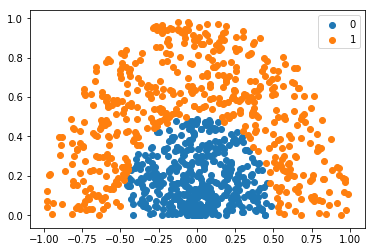

In [4]:

plt.scatter(X[y==0, 0], X[y==0, 1], label='0')
plt.scatter(X[y==1, 0], X[y==1, 1], label='1')
plt.legend()
plt.show()


## Skewing

In [5]:
def skew(X, z):
    x = X[:, 0]
    y = X[:, 1]
    theta = np.arctan2(y, x) + z
    r = np.sqrt(x*x + y*y)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    X_skew = np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1)], axis=1)
    return X_skew

# def skew(X, z=0):
#     """
#     Skew the data.
    
#     Parameters
#     ----------
#         X : the given 2D data
#         z : the nuisance parameter
#     Return
#     ------
#         X_skewed :
#     """
#     X_2 = X*X
#     rho = np.sqrt(X_2[:,0]+X_2[:,1])
#     theta = np.arctan2(X[:, 1], X[:, 0]) # WTF ! arctan2(x*x / y*y) ???
#     theta = theta + z
#     X_2[:, 0] = rho*np.cos(theta)
#     X_2[:, 1] = rho*np.sin(theta)
#     return X_2

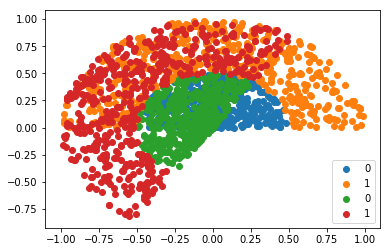

In [6]:
X_skew = skew(X, 45)
plt.scatter(X[y==0, 0], X[y==0, 1], label='0')
plt.scatter(X[y==1, 0], X[y==1, 1], label='1')
plt.scatter(X_skew[y==0, 0], X_skew[y==0, 1], label='0')
plt.scatter(X_skew[y==1, 0], X_skew[y==1, 1], label='1')
plt.legend()
plt.show()


# Base

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib


In [8]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable


In [9]:
class WeightedCrossEntropyLoss(nn.Module):
    def forward(self, input, target, weight):
        element_loss = F.cross_entropy(input, target, reduce=False)
        loss = torch.mean(element_loss * weight)
        return loss


In [10]:
from models.net.weighted_criterion import WeightedMSELoss

In [11]:
def bound(X, y, predict_fn, ax=None, cmap='PuBuGn'):
    """
    Plot the bounds of a 2D dataset (X,y) given a probability prediction
    function.
    
    Params
    ------
        X: the data
        y: the true labels
        predict_fn: the probability prediction function
        ax: (default=None) the axes
    Return
    ------
        fig: the figure
        ax: the axes
    """
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                         np.arange(y_min, y_max, .02))
    Z = predict_fn( (np.c_[xx.ravel(), yy.ravel()]).astype(np.float32) )
    Z = np.array(Z)[:, 1]
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    m = ax.contourf(xx, yy, Z, cmap=cmap, alpha=.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='b', cmap=m.cmap)
    cb = fig.colorbar(m)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return fig, ax

# Neural net

## Model

In [12]:
from models.pizza import NeuralNetModel

## Training

In [13]:
model = NeuralNetModel(n_steps=1000)

In [14]:
#model.fit(X[:50], y[:50])
model.fit(X, y)


NeuralNetModel(batch_size=20, cuda=False, learning_rate=0.001, n_steps=1000,
        verbose=0)

In [15]:
model.score(X, y)

0.98699999999999999

In [16]:
model.save('../savings')

NeuralNetModel(batch_size=20, cuda=False, learning_rate=0.001, n_steps=1000,
        verbose=0)

In [17]:
model.load("../savings")

NeuralNetModel(batch_size=20, cuda=False, learning_rate=0.001, n_steps=1000,
        verbose=0)

## Evaluation

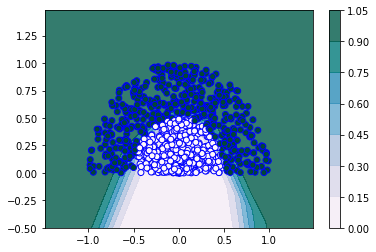

In [18]:
bound(X, y, model.predict_proba)
plt.show()

In [19]:
print(model.get_params())

{'batch_size': 20, 'cuda': False, 'learning_rate': 0.001, 'n_steps': 1000, 'verbose': 0}


# Data Augmentation

## Model

In [20]:
from models.pizza import AugmentedNeuralNetModel

## Training

In [21]:
model = AugmentedNeuralNetModel(skew, n_steps=3000, width=1)

In [22]:
model.fit(X, y)

AugmentedNeuralNetModel(batch_size=20, cuda=False, learning_rate=0.001,
            n_augment=2, n_steps=3000, skewing_function=None, verbose=0,
            width=1)

In [23]:
model.score(X, y)

0.98299999999999998

In [24]:
model.augmenter.sample_z(35)

array([-0.08834581,  0.91094349, -0.02341567,  0.79602504,  0.50305244,
       -0.23591151, -1.02465823,  2.03509457, -0.12888345, -0.16935888,
        0.3682191 , -0.18678084,  0.18108944, -0.40123709, -0.57981926,
       -1.50842334, -0.87901399, -0.67102805, -1.91769857, -0.62744749,
       -1.46022321, -0.43718734, -1.11012534, -0.63310849, -1.01690877,
       -2.12066177, -0.40272321,  0.46291834, -0.91694253, -0.91863429,
       -0.35096202,  0.08003431, -0.19030748, -0.79736167,  1.25118223])

##  Evaluation


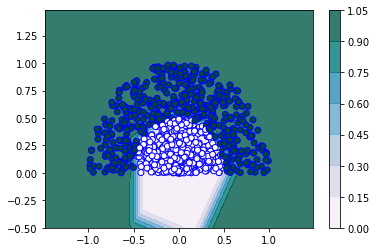

In [25]:
bound(X, y, model.predict_proba)
plt.show()

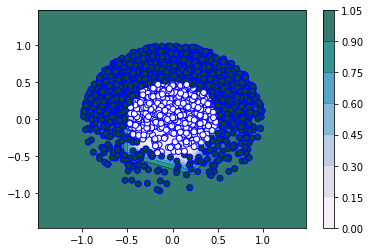

In [26]:
X_aug, y_aug, _ = model.augmenter(X, y)
bound(X_aug, y_aug, model.predict_proba)
plt.show()

# Tangent Prop

## Tangent computer

In [27]:
from models.tangent_extract import TangentExtractor
from models.pizza.tangent_prop_model import TangentComputer


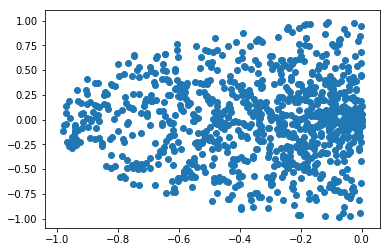

In [28]:
te = TangentExtractor(skew, alpha=1e-6)

T_approx = te.compute_tangent(X)

plt.scatter(T_approx[:, 0], T_approx[:, 1])
plt.show()

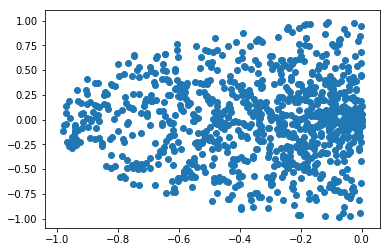

In [29]:
te = TangentComputer()

T = te.compute_tangent(X)

plt.scatter(T[:, 0], T[:, 1])
plt.show()

## Network structure

## Model

In [30]:
from models.pizza import TangentPropModel

## Training

In [49]:
model = TangentPropModel(skew, n_steps=5000, learning_rate=0.05, trade_off=100)

In [50]:
model.fit(X, y)

TangentPropModel(alpha=0.01, batch_size=20, cuda=False, learning_rate=0.05,
         n_steps=5000, skewing_function=<function skew at 0x7f18664a16a8>,
         trade_off=100, verbose=0)

In [51]:
model.score(X, y)

0.96199999999999997

## Evaluation

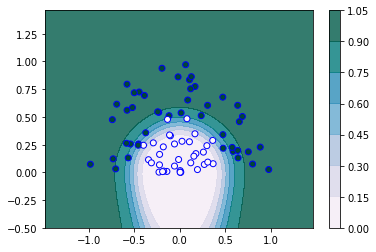

In [52]:
bound(X[:80], y[:80], model.predict_proba)
plt.show()

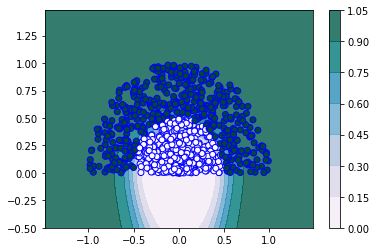

In [53]:
bound(X, y, model.predict_proba)
plt.show()

# Pivot adversarial

### Get z

In [36]:
class ZComputer(object):
    def __init__(self):
        super().__init__()

    def compute_z(self, X):
        x = X[:, 0]
        y = X[:, 1]
        z = np.arctan2(y, x)
        return z
    

In [37]:
z = ZComputer().compute_z(X)

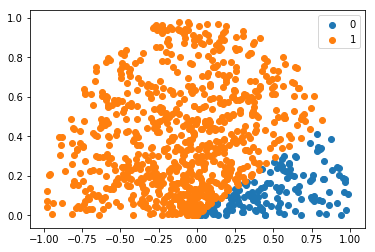

In [38]:
threshold = 0.5  # rad
plt.scatter(X[z<threshold, 0], X[z<threshold, 1], label='0')
plt.scatter(X[z>threshold, 0], X[z>threshold, 1], label='1')
plt.legend()
plt.show()


## Model


In [39]:
from models.pizza import PivotModel


## Training

In [40]:
model = PivotModel(n_steps=3000, n_clf_pre_training_steps=500, n_adv_pre_training_steps=100,
                   n_recovery_steps=5, trade_off=5)

In [41]:
model.fit(X, y)


PivotModel(adversarial_learning_rate=0.001, batch_size=20,
      classifier_learning_rate=0.001, cuda=False,
      n_adv_pre_training_steps=100, n_clf_pre_training_steps=500,
      n_recovery_steps=5, n_steps=3000, trade_off=5, verbose=0)

In [42]:
model.score(X, y)

0.98199999999999998

## Evaluation

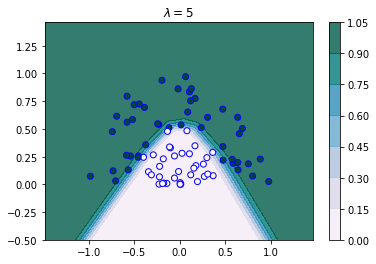

In [43]:
bound(X[:80], y[:80] , model.predict_proba)
plt.title( '$\lambda = {}$'.format(model.trade_off) )
plt.show()

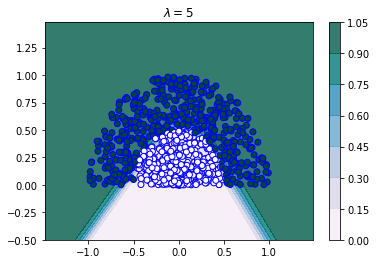

In [44]:
bound(X, y , model.predict_proba)
plt.title( '$\lambda = {}$'.format(model.trade_off) )
plt.show()

Je pense que le problème ici c'est qu'on peut satisfaire à la fois le classifier et bloquer l'adversaire avec le pré-training.

À tester si l'adversaire apprend quelque chose ou pas.

De + si on ajoute des points dans un espace qui était libre auparavant alors l'augmentation de donnée fait déjà le travail de contraindre le modèle en y plaçant des points à classer correctement. Du coup l'augmentation est bien plus logique pour ce cas.



In [47]:
model.get_params()

{'adversarial_learning_rate': 0.001,
 'batch_size': 20,
 'classifier_learning_rate': 0.001,
 'cuda': False,
 'n_adv_pre_training_steps': 100,
 'n_clf_pre_training_steps': 500,
 'n_recovery_steps': 5,
 'n_steps': 3000,
 'trade_off': 5,
 'verbose': 0}

In [48]:
model.describe()

{'adversarial_learning_rate': 0.001,
 'batch_size': 20,
 'classifier_learning_rate': 0.001,
 'n_adv_pre_training_steps': 100,
 'n_clf_pre_training_steps': 500,
 'n_recovery_steps': 5,
 'n_steps': 3000,
 'name': 'pivot',
 'trade_off': 5}